Freeze-out: particles will stay in thermal equilibrium with the universe as long as the reactions keeping them in chemical equilibrium are proceeding at a rate higher than the expansion of the universe. If the expansion rate is faster than the reaction rate, the partices can no longer stay in equilibrium with the universe; they are 'frozen out'.

## TODO:
Plot Omega of cold DM for different cross-sections sigma

## done:
Write functions to calculate the equilibrium number density of particles as a function of temperature (for the relativistic and non-relativistic cases).

Write functions to calculate the Hubble constant and g_{*S} as a function of temperature.

Plot the present-day abundance (Omega) of hot dark matter (where T_fo >> m) for different masses and cross sections. How does it scale with these variables?

Use the equipartition theorem to find the velocity of cold DM (currently approximated as c)

Rearrange cells in a proper order, import everything at start

Plot Omega of cold DM for different masses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.optimize import fsolve
from scipy.misc import derivative
from scipy.integrate import odeint
from scipy.interpolate import interp1d
#import seaborn as sns

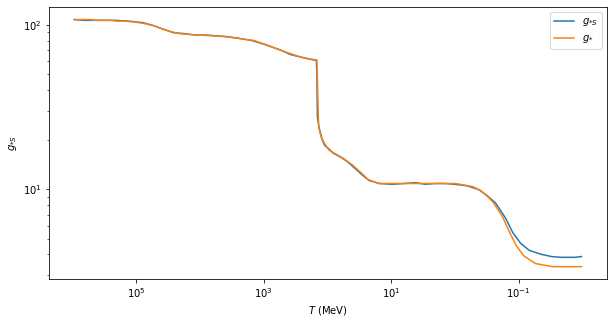

In [2]:
gstar_data = np.genfromtxt('gstar.csv', delimiter=',')

Ts_S=gstar_data[:,0]*10**6
Ts=gstar_data[:,2]*10**6
gstar_S=interp1d(Ts_S, gstar_data[:,1],kind='nearest',fill_value='extrapolate')
gstar=interp1d(Ts, gstar_data[:,3],kind='nearest',fill_value='extrapolate')

plt.figure(figsize=(10,5))
plt.plot(Ts_S*10**-6,gstar_S(Ts_S), label=r'$g_{*S}$')
plt.plot(Ts*10**-6,gstar(Ts), label=r'$g_{*}$')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$g_{*S}$')
plt.xlabel(r'$T$ (MeV)')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [3]:
#define functions for converting between temperature T and
#scale factor a
T_0 = 0.235e-3
def T_to_a(T):
    return (gstar_S(T_0)/gstar_S(T))**(1/3)*(T_0/T)
def a_to_T(a):
    func = lambda T: a**3*(gstar_S(T))*T**3-gstar_S(T_0)*T_0**3
    T_initial_guess = gstar_S(T_0)**(1/3)*(T_0/a)
    T_solution = fsolve(func, T_initial_guess)
    return T_solution

In [80]:
#define parameters and functions for calculating
#present-day abundance of DM

#all parameters in natural units
G_F = 1.1663787*10**(-5)/((10**9)**2)
M_pl = 2.435*10**18*10**9
k_B = 1
c = 1
#assuming DM particles to be fermions
g = 2
crit_density = 8.07*10**(-47)*10**36

#rough approximations of H, n, and sigma. Replace freely
def H(T):
    return np.pi/3*(gstar(T)/10)**(1/2)*(T**2)/M_pl

#assuming DM particles to be fermions. rel = True -> hot DM
def n(T,rel=True,m=0):
    if rel:
        return 3/4*scipy.special.zeta(3)/(np.pi**2)*g*T**3
    else:
        if m == 0:
            raise Exception("for cold DM, mass needs to be specified")
        else:
            return g*(m*T/(2*np.pi))**(3/2)*np.exp(-m/T)

#average velocity of DM. Default = hot DM.
def v(T,rel=True,m=0):
    if rel == True:
        return c
    else:
        if m == 0:
            raise Exception("for cold DM, mass needs to be specified")
        else:
            return (3*k_B*T/m)**(1/2)

#cross-section of DM self-interaction. The parameter alpha can be varied for
#easy plotting of different values of sigma
def sigma(T,alpha=1):
    return alpha*(G_F**2)*(T**2)
    
#solve for freeze-out temperature T_fo
def T_fo_solver(rel=True,alpha=1,m=0):
    composite = lambda T: H(T) - (n(T,rel=rel,m=m)*v(T,rel=rel,m=m)*sigma(T,alpha))
    T_initial_guess = 10**12
    return fsolve(composite,T_initial_guess)

#present-day abundance of dark matter
def Omega(T,m,rel=True):
    return dm_density(T,m,rel)/crit_density

#dark matter density TODAY. n is the DM density at the decoupling, which needs
#to be multiplied by a scaling factor a^-3 accounting for expansion
def dm_density(T,m,rel=True):
    return m*n(T,rel,m)*T_to_a(T)**3

In [5]:
#plot Hubble constant at various temperatures
#T_vect_temp = np.linspace(1,100);
#H_vect_temp = [];
#m_temp = 1;
#sigma_temp = 1;
#for T in T_vect_temp:
#    H_vect_temp.append(H(T));
#plt.plot(T_vect_temp,H_vect_temp);
#plt.xlabel("Freeze-out temperature T");
#plt.ylabel("Hubble constant H");
#plt.show();

## Hot dark matter

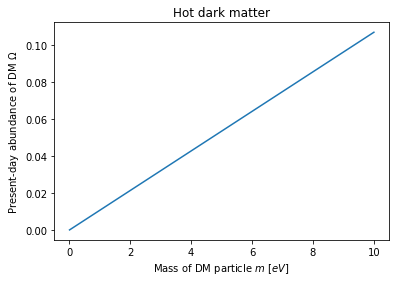

In [74]:
#plot Omega as a fn of m with constant sigma
m_vect = np.linspace(0.01,10,100)
Omega_vect = []
for m in m_vect:
    T_fo = T_fo_solver(rel=True,m=m)[0]
    Omega_vect.append(Omega(T_fo,m,True))
    
plt.plot(m_vect,Omega_vect)
plt.title("Hot dark matter")
plt.xlabel("Mass of DM particle $m$ [$eV$]")
plt.ylabel("Present-day abundance of DM $\Omega$")
plt.show()

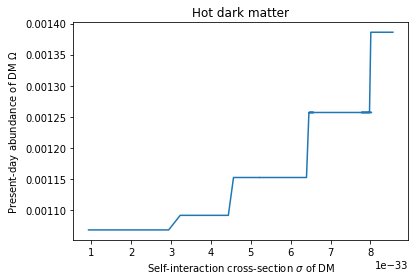

In [76]:
#plot Omega as a fn of sigma with constant m. parameter alpha
#defined for ease of plotting, see fn sigma
m_const = 0.1
alpha_vect = np.linspace(1,1000,100)
sigma_vect = []
Omega_vect = []
for alpha in alpha_vect:
    T_fo = T_fo_solver(rel=True,alpha=alpha,m=m_const)[0]
    sigma_vect.append(alpha*G_F**2*T_fo**2)
    Omega_vect.append(Omega(T_fo,m_const,True))
plt.plot(sigma_vect,Omega_vect)
plt.title("Hot dark matter")
plt.xscale('linear')
plt.xlabel("Self-interaction cross-section $\sigma$ of DM")
plt.ylabel("Present-day abundance of DM $\Omega$")
plt.show()

## Cold dark matter

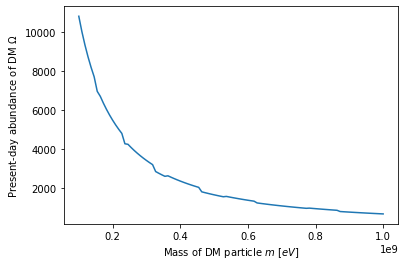

In [71]:
#plot Omega as a fn of m with constant sigma
m_vect = np.linspace(0.1*10**9,1*10**9,100)
Omega_vect = []
for m in m_vect:
    T_fo = T_fo_solver(rel=False,alpha=1,m=m)[0]
    Omega_vect.append(Omega(T_fo,m,False))
    
plt.plot(m_vect,Omega_vect)
plt.xlabel("Mass of DM particle $m$ [$eV$]")
plt.ylabel("Present-day abundance of DM $\Omega$")
plt.show()

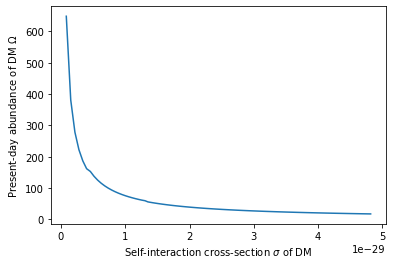

In [42]:
#plot Omega as a fn of sigma with constant m. parameter alpha
#defined for ease of plotting, see fn sigma
m_const = 10**9
alpha_vect = np.linspace(1,100,100)
sigma_vect = []
Omega_vect = []
for alpha in alpha_vect:
    T_fo = T_fo_solver(rel=False,alpha=alpha,m=m_const)[0]
    sigma_vect.append(alpha*G_F**2*T_fo**2)
    Omega_vect.append(Omega(T_fo,m_const,False))
plt.plot(sigma_vect,Omega_vect)
plt.xscale('linear')
plt.xlabel("Self-interaction cross-section $\sigma$ of DM")
plt.ylabel("Present-day abundance of DM $\Omega$")
plt.show()

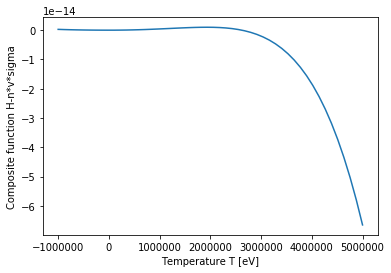

Freeze-out temperature T_fo = 2620352.6103422274 eV


In [64]:
#sanity check for T_fo_solver. Plot composite function for hot DM, make sure that the roots are valid

def T_fo_solver_copy(rel=True,alpha=1,m=0):
    composite = lambda T: H(T) - (n(T,rel=rel,m=m)*v(T,rel=rel,m=m)*sigma(T,alpha))
    T_vect = np.linspace(-10**6,5*10**6)
    composite_vect = []
    for i in T_vect:
        composite_vect.append(composite(i))
    plt.plot(T_vect,composite_vect)
    plt.xlabel("Temperature T [eV]")
    plt.ylabel("Composite function H-n*v*sigma")
    plt.show()
    T_initial_guess = 10**12
    return fsolve(composite,T_initial_guess)

print("Freeze-out temperature T_fo = {} eV".format(T_fo_solver_copy()[0]))

$T_{fo} \sim MeV$. Reasonable, as this is approximately the freeze-out temperature of neutrinos.  We're treating very light DM particles of relativistic speeds - basically neutrinos.

/home/anders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/home/anders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
/home/anders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


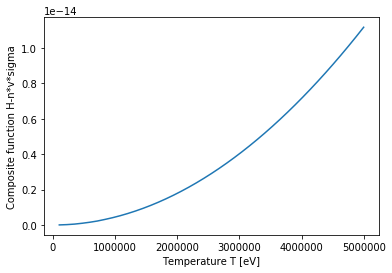

Freeze-out temperature T_fo = 78585735.83936624 eV
v = 0.48554835754855424


In [103]:
#sanity check for T_fo_solver. Plot composite function for cold DM, make sure that the roots are valid

#calculate T_fo for cold DM of mass 1 GeV
T_fo_test = T_fo_solver_copy(False,1,10**9)[0]
print("Freeze-out temperature T_fo = {} eV".format(T_fo_test))

#calculate v for cold DM of mass 1 GeV
print("v = {}".format(v(T_fo_test,False,10**9)))

In [107]:
#Calculate T_fo for cold DM with m = 0.01 GeV and sigma*v = 6.94379e-29 eV^-2
def T_fo_solver_fixed_sigma(sigma_v_fixed,rel=True,m=0):
    composite = lambda T: H(T) - (n(T,rel=rel,m=m)*v(T,rel=rel,m=m)*sigma_v_fixed/v(T,rel=rel,m=m))
    T_initial_guess = 10**12
    return fsolve(composite,T_initial_guess)

T_fo_solver_fixed_sigma(6.94379*10**-29,False,0.01*10**9)

array([739885.06906731])